In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

### Numerical approximation for simple harmonic oscillator (4 points)

Create a numerical approximation of the simple harmonic oscillator using the Euler method. Visualize different approximations as a function of the step size. You may only make use of the packages listed above.

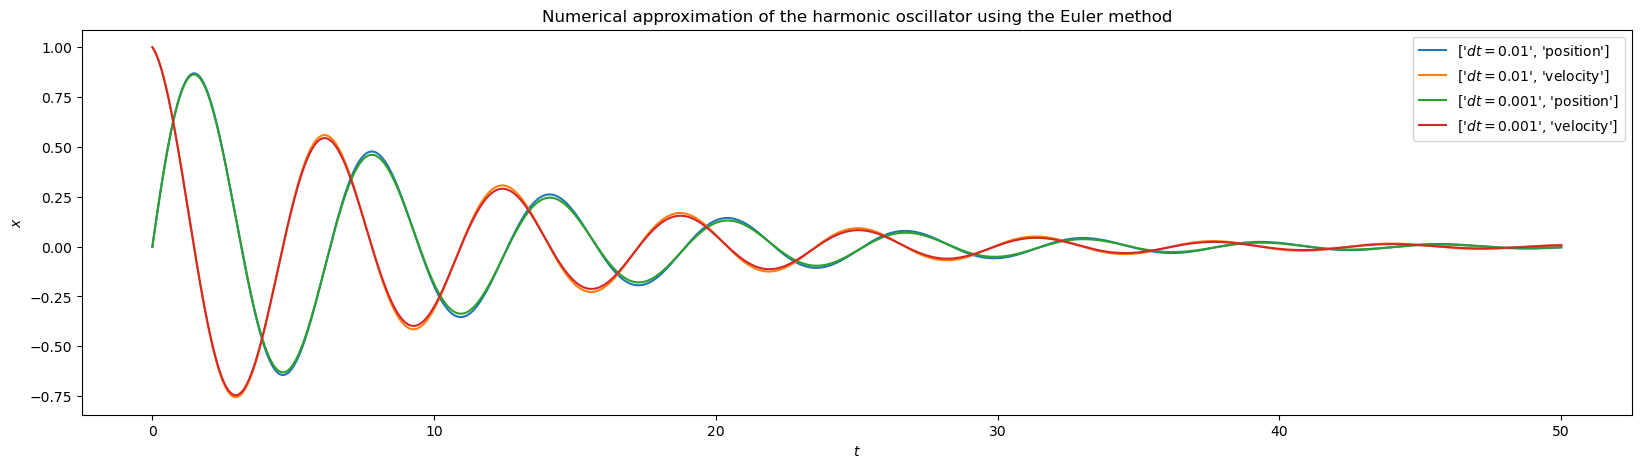

In [14]:
step_size = [0.01, 0.001]  # the different step sizes (dt) to plot
interval = 50  # total time interval for t from [0, interval]
initial_condition = (0, 1)  # position and velocity

k = 1     # spring constant
m = 1     # mass hanging from spring
c = 0.2   # damping coefficient

omega = np.sqrt(k / m)
gamma = c / m  

legend = []
plt.figure(figsize=(20,5))

for dt in step_size:
  x = [initial_condition]
  t = [0]
  
  index = 1
  
  while t[-1] < interval:
    old_position = x[index - 1][0]
    old_velocity = x[index - 1][1]
    
    new_position = old_position + dt * old_velocity
    new_velocity = old_velocity + dt * (-(omega**2) * old_position - gamma * old_velocity)

    x.append((new_position, new_velocity))
    t.append(t[-1] + dt)
    
    index += 1

  plt.plot(t, list(map(lambda y: y[0], x)))
  plt.plot(t, list(map(lambda y: y[1], x)))

  legend.append([f"$dt={dt}$", "position"])
  legend.append([f"$dt={dt}$", "velocity"])

plt.xlabel(r"$t$")
plt.ylabel(r"$x$")

plt.legend(legend)
plt.title('Numerical approximation of the harmonic oscillator using the Euler method')

plt.savefig('euler.png')
plt.show()

### Lotka-Volterra model (4 points)

Simulate the Lotka-Volterra model using the RK4(5) method. Visualize the population dynamics for predator and prey. Here, you may make use of the `solve_ivp` method in `scipy.integrate`.

In [15]:
# the butcher table definition
# as per https://en.wikipedia.org/wiki/Runge-Kutta-Fehlberg_method

C = [0, 1/4, 3/8, 12/13, 1, 1/2]
A = [
    [1/4],
    [3/32, 9/32],
    [1932/2197, -7200/2197, 7296/2197],
    [439/216, -8, 3680/513, -845/4104],
    [-8/27, 2, -3544/2565, 1859/4104, -11/40]
]
B = [
    [16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55],
    [25/216, 0, 1408/2565, 2197/4104, -1/5, 0]
]

T = [A, B, C]

In [16]:
# the model differential equations and parameters

initial_state = np.array((1, 1))  # number of preys and number of predators 

alpha = 1.1    # growth rate pray
beta = 0.4     # death rate pray
theta = 0.1    # growth rate predator
gamma = 0.4    # death rate predator

def f(_t, y0, y1):
    return np.array([alpha * y0 - beta * y0 * y1, theta * y0 * y1 - gamma * y1])

names = ['prey', 'predator']
n = len(names)

In [17]:
# simulation details

interval = 50    # total time interval for t from [0, interval]
h_init = 0.01    # timestep at the start

epsilon = 1e-6  # the error accuracy to aim for

In [18]:
def runge_kutta(f, t, h, s, T):
    """
    f: system of equations
    t: current time
    h: stepsize
    s: the current state
    A, B, C = T: the butcher table
    """
    
    A, B, C = T

    # compute all the values for k_i
    ks = [f(t, *s)]
    for i in range(len(C) - 1):
        ks.append(f(t + C[i + 1] * h, *(s + h * np.dot(A[i], ks))))

    # compute RK4 and RK5 for the error estimate
    RKF4 = s + h * np.dot(B[1], ks)
    RKF5 = s + h * np.dot(B[0], ks)    
    error = np.linalg.norm(abs(RKF4 - RKF5))  # the error estimate

    # compute the new value for h
    h_new = 0.9 * h * (epsilon / error)**0.2
    
    # reject the step and decrease the stepsize
    if error > epsilon:
        return runge_kutta(f, t, h_new, s, T)
    
    # accept the step and increase the stepsize
    t = t + h
    s = RKF5
    h = h_new

    return t, h, s

In [19]:
# run the simulation

states = [initial_state]
t = [0]
h = [h_init]

while t[-1] < interval:
    new_t, new_h, s = runge_kutta(f, t[-1], h[-1], states[-1], T)
    
    states.append(s)
    t.append(new_t)
    h.append(new_h)

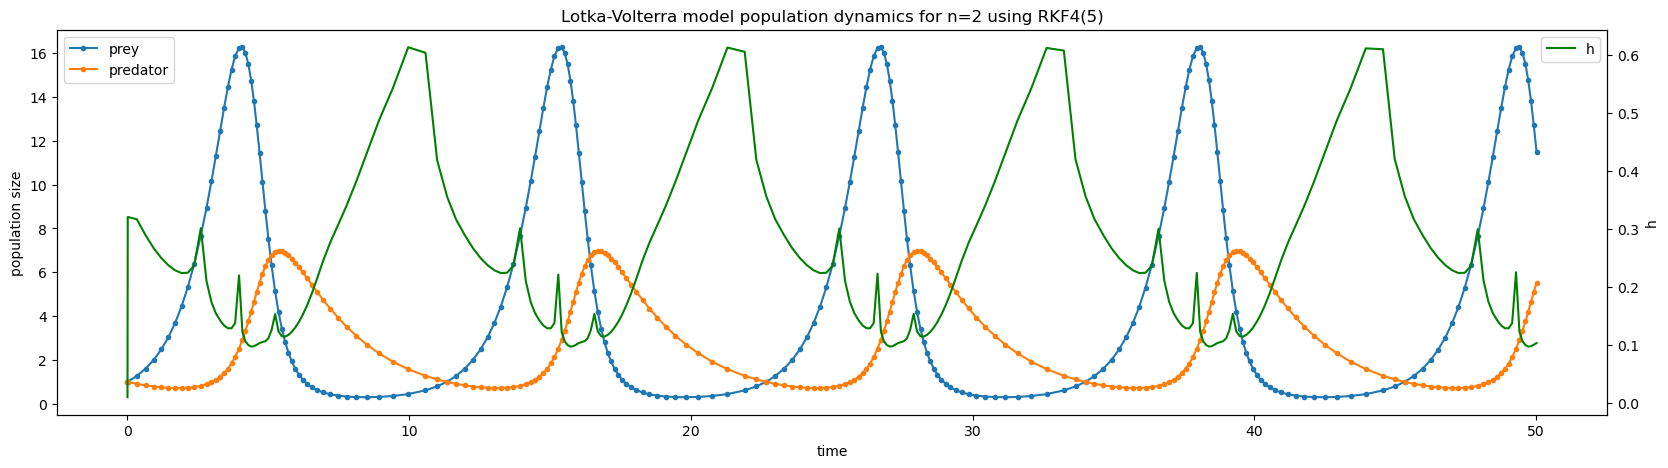

In [20]:
fig, ax = plt.subplots(figsize=(20,5))

# plot the dynamical system equations
for i in range(n):
    ax.plot(t, list(map(lambda s: s[i], states)), marker='.')

ax.legend(names)
ax.set_ylabel("population size")

# plot the simulation variable h
ax2 = ax.twinx()

ax2.plot(t, h, color='green')

ax2.legend('h')
ax2.set_ylabel("h")

# show the whole plot
ax.set_xlabel("time")
plt.title(f'Lotka-Volterra model population dynamics for n={n} using RKF4(5)')

plt.savefig('RKF45.png')
plt.show()